# Segmentation of mammo tiles

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.core import *
from fastai import *
from fastai.vision import *
import PIL

from pathlib import *
import pandas as pd
import numpy as np
import colorcet as cc

cmap_grey = cc.cm.linear_grey_0_100_c0

In [4]:
#path  = Path('../../data/DDSM-hm2dg_2')
path  = Path("../../Dropbox/mammography-data/equalized2dg_tiles")
#print(list(path.iterdir()))
d_im  = "tiles"
d_msk = "masks"

In [5]:
cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
cases.drop("Unnamed: 0",axis=1,inplace=True)
display(cases.tail(2))

gp = cases.groupby( ["purpose", "simple_pathology", "abnormality type"])["fnImage"].count()
print( gp )
print(cases.columns)

,case_id,height,width,simple_pathology,patient_id,purpose,breast density,left or right breast,image view,abnormality id,...,pAir,pHealthy,pBenign,pMalignant,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask
161115,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,34987,0,15189,0.74,0.32,50176,14847,train/Mass-Training_P_02092_LEFT_MLO_tile_1694...,train/Mass-Training_P_02092_LEFT_MLO_tile_1694...
161116,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,35698,0,14478,0.74,0.27,50176,14847,train/Mass-Training_P_02092_LEFT_MLO_tile_1691...,train/Mass-Training_P_02092_LEFT_MLO_tile_1691...


purpose  simple_pathology            abnormality type
test     BENIGN                      calcification        8114
                                     mass                11534
         BENIGN;MALIGNANT            calcification         116
                                     mass                  142
         MALIGNANT                   calcification        5692
                                     mass                 7931
train    BENIGN                      calcification       37632
                                     mass                33272
         BENIGN;MALIGNANT            calcification         106
                                     mass                  145
         BENIGN;MALIGNANT;MALIGNANT  mass                  177
         MALIGNANT                   calcification       23982
                                     mass                31920
         MALIGNANT;BENIGN            calcification         290
                                     mass                   64
N

In [6]:
def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll

In [7]:
complexity={
#            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
            "pMalignant":"pMalignant > 0.1*tile_size and pMalignant > 0.62*obsAreas and pBenign==0 and pAir==0",
#            "pAir":"pAir>0.2 and pAir<1.0", 
            "pBenign":"pBenign/tile_size>0.4 and pMalignant==0 and pAir==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=25
cases = cases[cases["abnormality type"]=="calcification"]
display(cases["abnormality type"].tail(5))

test  = selectCases( cases, "test",     complexity=complexity, nb=nb//2 )
train = selectCases( cases, "train", complexity=complexity, nb=nb )
cases = train.append( test, ignore_index=False )
cases.reset_index(drop=True,inplace=True)

print(f"Total: {cases.shape[0]}")
gp = cases.groupby( ["purpose", "abnormality type", "classes"])["fnImage"].count()
print( gp )

#generate training and validation csv for fastai
dfData = cases.loc[: , ["purpose", "classes", "fnImage", "fnMask" ]]
dfData.to_csv( path / "tvData.csv", index=False)
dfData.head(2)
cases=None

75927    calcification
75928    calcification
75929    calcification
75930    calcification
75931    calcification
Name: abnormality type, dtype: object

Total: 74
purpose  abnormality type  classes   
test     calcification     pBenign       12
                           pMalignant    12
train    calcification     pBenign       25
                           pMalignant    25
Name: fnImage, dtype: int64


In [8]:
#function to open 16bit as rgb withut loosing precision
def open_image_16bit2rgb( fn ): 
    a = np.asarray(PIL.Image.open( fn ))
    a = np.expand_dims(a,axis=2)
    a = np.repeat(a, 3, axis=2)
    return Image( pil2tensor(a, np.float32 ).div(65535) )
def open_mask_special( fn ): 
    a = PIL.Image.open( fn )
    a = (np.asarray(a)/127).astype(np.int)
    return ImageSegment( pil2tensor(a, np.float32 ))

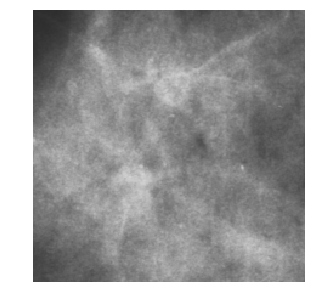

In [9]:
fnImage = path/d_im/dfData.fnImage.iloc[-1]
im=open_image_16bit2rgb(fnImage)
show_image( im, figsize=(5,5) )

1

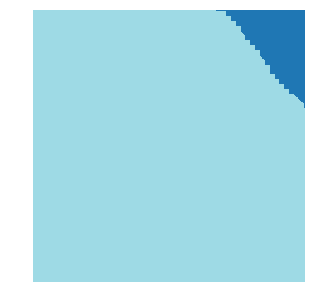

In [10]:
fnMask = path/d_msk/dfData.fnImage.iloc[-1]
mask   = open_mask_special(fnMask)
mask.show(figsize=(5,5), alpha=1)
np.max(mask.data.numpy())

In [11]:
print(mask.shape,mask.data)
print(mask.shape,mask.data.max())

torch.Size([1, 224, 224]) tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])
torch.Size([1, 224, 224]) tensor(1)


In [12]:
codes =["normal", "benign", "malignant"] 

In [13]:
fnImages = join_paths(dfData.fnImage.values, path/d_im)
fnMasks  = join_paths(dfData.fnMask.values, path/d_msk)
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False
dsTrain  = SegmentationDataset(join_paths(dfData.fnImage[ixTrain].values, path/d_im), 
                               join_paths(dfData.fnImage[ixTrain].values, path/d_msk), 
                               codes)
dsValid  = SegmentationDataset(join_paths(dfData.fnImage[ixValid].values, path/d_im), 
                               join_paths(dfData.fnImage[ixValid].values, path/d_msk), 
                               codes)
dsTrain.image_opener = dsValid.image_opener = open_image_16bit2rgb
dsTrain.mask_opener  = dsValid.mask_opener  = open_mask_special


In [14]:
def getSegmentationTransforms():
    max_zoom     = 1.1
    max_rotate   = 0.1
    max_lighting = 0 #0.2
    max_warp     = 0.01
    tfmTrain =[]
    #tfmTrain.append( rand_crop() )
    tfmTrain.append( dihedral_affine() )
    tfmTrain.append( flip_affine(p=0.5) )
    #tfmTrain.append( skew( np.arange, p=0.75) )
    tfmTrain.append( symmetric_warp(magnitude=(-max_warp,max_warp), p=0.75) )
    tfmTrain.append( perspective_warp(magnitude=(-max_warp,max_warp), p=0.75) )
    
    tfmTrain.append( rotate(degrees=(-max_rotate,max_rotate), p=.25) )
    #tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )

    tfmTrain.append( jitter(magnitude=0.01) )
    
    if max_lighting > 0:
        tfmTrain.append( brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=0.75) )
        tfmTrain.append( contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting) )
    
    tfmValid =[crop_pad()]
    return (tfmTrain, tfmValid)

In [15]:
tfms       = getSegmentationTransforms()
dsTrainTfm = DatasetTfm(dsTrain, tfms[0], tfm_y=True)
dsValidTfm = DatasetTfm(dsValid, tfms[1], tfm_y=True)


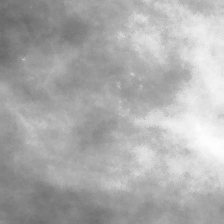

In [16]:
dsTrainTfm[0][0]

In [17]:
data = ImageDataBunch.create(dsTrainTfm, 
                             dsValidTfm, 
                             bs=8, 
                             size=224
                            )
data.normalize(imagenet_stats)

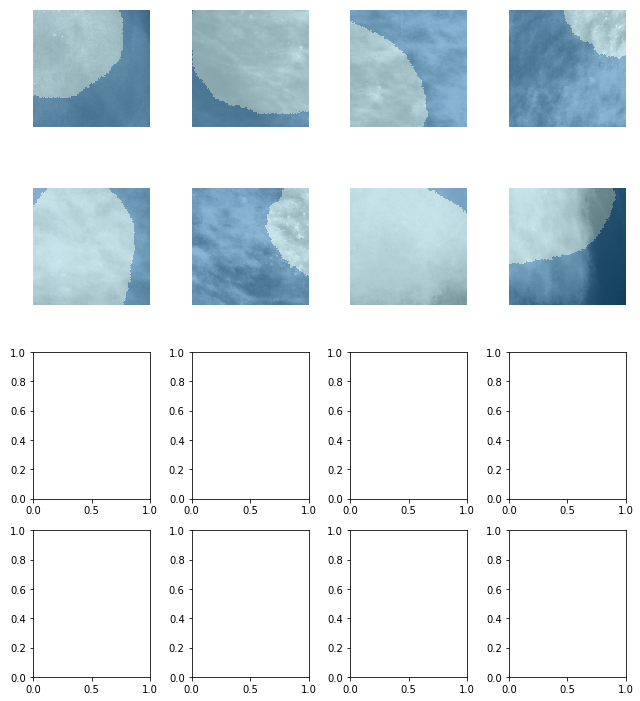

In [18]:
data.show_batch(4)

In [19]:
print(data.classes)
len(data.classes),data.c

['normal', 'benign', 'malignant']


(3, 3)

In [52]:
void_code = 0

class Dummy:
    i=0
    inp = None
    tg = None
    
    @staticmethod
    def accuracy(input, target):
        if Dummy.i < 10:
            print(f"input.shape: {input.shape} - target.shape:{target.shape}")
            Dummy.i+=1
            Dummy.inp=input.data.numpy().copy()
            Dummy.tg = target.data.numpy().copy()
        
        
        target = target.squeeze()
        mask = target != void_code
        return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    

In [53]:
#learn = create_cnn( data, models.resnet34, metrics=error_rate )
#learn = Learner.create_unet(data, models.resnet18, metrics=acc_camvid)
learn = Learner.create_unet(data, models.resnet18, metrics=Dummy.accuracy)
#learn = Learner_create_unet(Learner,data, models.resnet18, metrics=acc_camvid)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


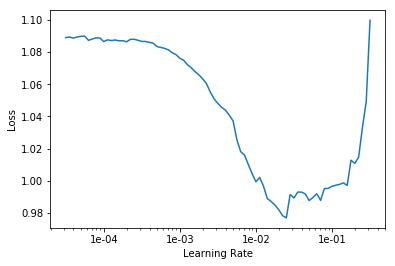

In [42]:
lr_find(learn, start_lr = 1e-05,end_lr=1.0 )
learn.recorder.plot()

In [54]:
lr_last_layer=0.01
learn.fit_one_cycle(1, max_lr=lr_last_layer)

Total time: 00:34
epoch  train_loss  valid_loss  accuracy
1      1.085148    98.806831   0.683786  (00:34)



2
(8, 3, 224, 224)
(8, 1, 224, 224)


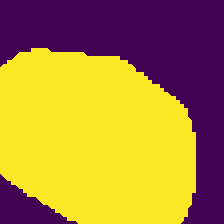

In [71]:
print(Dummy.i)
print(Dummy.inp.shape)
print(Dummy.tg.shape)

i=1
Image(tensor(Dummy.inp[i]))
Image(tensor(Dummy.tg[i]))


In [27]:
learn.save('mammo-resnet18-p-stage-1')

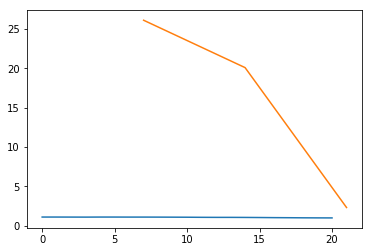

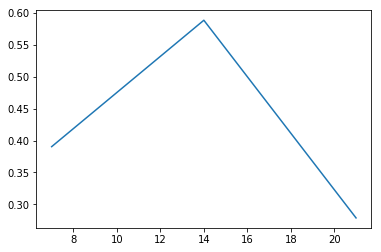

In [28]:
learn.recorder.plot_losses(), plt.show()
learn.recorder.plot_metrics()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
learn.load('mammo-resnet34-p-stage-1')

In [ ]:
print("pretrain learning rate: ", lr_last_layer)
learn.lr_find(start_lr=1e-8*lr_last_layer, end_lr=50*lr_last_layer, num_it=200)
learn.recorder.plot(skip_start=1, skip_end=2)

In [ ]:
max_lr = lr_last_layer*0.75
min_lr = max_lr*1e-4
print(f"unfreeze learning slice: {min_lr:.2e} to {max_lr:.2e} ")

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10,  max_lr=slice(min_lr,max_lr))

In [ ]:
learn.recorder.plot_losses(), plt.show()
learn.recorder.plot_metrics()